# 운영체제 과제1
201901758 임베디드 시스템공학과 유승태

- 필요한 라이브러리, 함수 및 클래스 정의
 

In [46]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from math import lcm
from functools import reduce

pd.set_option('mode.chained_assignment',  None) # 경고 off


# json 파일을 읽어와서 dataframe으로 바꾸는 함수
def readJson(_num):
    # dataframe은 data 전역변수에 저장
    global data
    global is_realtime      # 읽어온 프로세스 셋이 리엍타임인지 아닌지
    is_realtime = False
    # 필요한 열 추가
    with open('{}.json'.format(_num)) as f:
        data = pd.DataFrame(json.load(f)).transpose()

        # period 속성이 있으면 리얼타임으로
        for i in data.columns:
            if(i == 'period'):
                is_realtime = True

        if(is_realtime == False):
            data['CPU_allocated'] = False               # 현재 프로세스가 CPU에 할당되어 있는지
            data['remain time'] = data['burst time']    # 프로세스가 완료되기까지 실행되야 하는 시간(남은 시간)
            data['turnaround time'] = 0                 
            data['waiting time'] = 0
            data['response time'] = 0
            data['waited on Q2'] = 0                    # Multi Level Feedback Queue 에서 Q2에서 대기한 시간 이 시간이 20이 되면 Q0로 승급
            data['allocated time'] = 0                  # round robin에서 CPU에 할당되어있던 시간. 이 시간이 time quauntum이 되면 context switching  
            
        elif(is_realtime == True):
            data['dead line']  = 0                      # 프로세스의 마감시간 (period와 같도록 설정)
            data['remain time'] = data['burst time']    # 프로세스가 완료되기까지 실행되야 하는 시간(남은 시간)
            data['remain time to dead line'] = 0        # 데드라인까지의 남은시간
            data['how many'] = 0                        # 프로세스가 몇번째 주기를 돌고 있는지
            data['CPU utilization'] = data['burst time'] / data['period']   # CPU 이용률
           

        data.index.name = 'Process'


# 간트차트를 그리는데 필요한 클래스
class GanntChart:
    # time_data에 프로세스이름, 할당 시작, 할당 끝의 시간을 [P1, 0, 5] 처럼 넣는다. 
    # chart_data에 time_data를 list 형태로 저장한다.
    # arrival_data는 real time 스케줄링에서 프로세스의 주기를 나타내기 위한 변수이다.
    def __init__(self):
        self.chart_data = []
        self.time_data = []
        self.arrival_data = []
        
    # time_data에 프로세스 이름, 시작 시간 추가
    def append_start(self,_p,_t):
        self.time_data.append(_p)
        self.time_data.append(_t)

    # time_data에 프로세스 끝 시간을 추가하여
    # chart_data에 추가하고 time_data는 클리어
    def append_end(self,_t):
        self.time_data.append(_t)
        self.chart_data.append(self.time_data.copy())
        self.time_data.clear()


    # 알고리즘 이름, 데이터프레임, 총 시간, CPU가 할당중이었던 시간을 받아와
    # 간트차트를 그리고, 성능을 출력해주는 함수.
    def drawChart(self,algorithm):

        # chart_data로 데이터 프레임을 만듦.
        df = pd.DataFrame(data= self.chart_data, columns= ['process','start','end'])

        # figsize 조정
        plt.figure(figsize=(13,1))


        # 수평막대그래프 그리기.
        plt.barh(y='Process', left=df['start'], width= df['end'] - df['start'], height= 0.4, edgecolor = 'black', color = 'white',)

        # 막대 안에 어떤 프로세스인지 text 삽입
        for i in df.index:
            plt.text(x=(df.loc[i,'start'] + df.loc[i,'end']) / 2, y=0, s=str(df.loc[i,'process']),ha = 'center', va = 'center')

        # real time 스케줄링에서 프로세스 주기를 화살표로 표시.
        for i in self.arrival_data:
            # print(i)
            plt.annotate(i[0],xy = (i[1],0.2), xytext=(i[1],0.5),arrowprops=dict(
                facecolor = 'black',
                fill = False,
            )
            )


        # 할당 시작, 할당 종료 시간을 중복을 제거하여 X축 눈금으로
        xticks = set(pd.concat([df['start'], df['end']]).tolist())
        plt.xticks(list(xticks))

        # title 및 x축 y축 이름
        plt.title(algorithm)
        plt.xlabel('Time')
        plt.ylabel('Process')

        # 차트 보여주기        
        plt.show()

        # def draw_rt_chart():



# 성능분석에 사용되는 클래스
class Perfomance:
    # 5가지 성능을 column으로 하는 dataframe을 만듦.
    def __init__(self):
        col = ['CPU utilization','Throughput','average turnaround time', 'average waiting time', 'average response time']
        self.perfomance = pd.DataFrame(columns=col)
        self.perfomance.index.name = 'Algorithm'
    
    # 하나의 알고리즘이 실행된 후, 이 함수를 통해 row 추가
    def append_data(self,algorithm, _data, _time, _using_time):
        # 성능 분석
        CPU_utilization = round(_using_time/_time,2)
        throughput = round(len(_data)/_time,2)
        ave_turnaround_time = round(_data['turnaround time'].mean(),2)
        ave_waiting_time = round(_data['waiting time'].mean(),2)
        ave_response_time = round(_data['response time'].mean(),2)
        
        row_data = [CPU_utilization,throughput, ave_turnaround_time, ave_waiting_time, ave_response_time]
        self.perfomance.loc[algorithm] = row_data


# Perfomance 객체 생성
perfomance_data = Perfomance()



- json 파일 읽기  
  
    몇번 json 파일을 읽을건지 설정

In [47]:
# readJson(1)
readJson(2)
# readJson(3)

## 스케줄링 알고리즘


### Not real time


  * FCFS(First-Come First-Served Scheduling)  
  선입 선처리 스케줄링  
  레디큐에 도착한 순서대로 처리하는 방식  
  
  

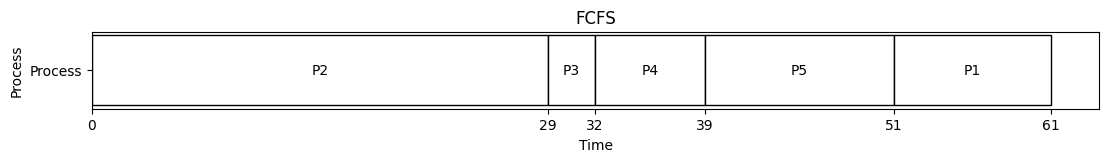

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               51            41   
P2                  0          29         2               29             0   
P3                  0           3         2               32            29   
P4                  0           7         2               39            32   
P5                  0          12         5               51            39   

         response time  
Process                 
P1                  41  
P2                   0  
P3                  29  
P4                  32  
P5                  39  


In [48]:

def FCFS(_data):

    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성

    # 스케줄링 시작
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                ready_queue.append(_data.loc[i])

        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐의 첫번째(가장 먼저 도착한) 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 레디큐에 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소 
        if(allocated_process != None):
            using_time += 1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료 
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('FCFS')        # 간트차트그리기
    perfomance_data.append_data('FCFS',_data,time, using_time)  # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(FCFS(data.copy()))


  * SJF(Shortest-Job-First) Non-Preemptive  
  도착한 프로세스 중, CPU 버스트가 가장 짧은 프로세스를 CPU에 먼저 할당하는 스케줄링 방식(비선점 형)
  

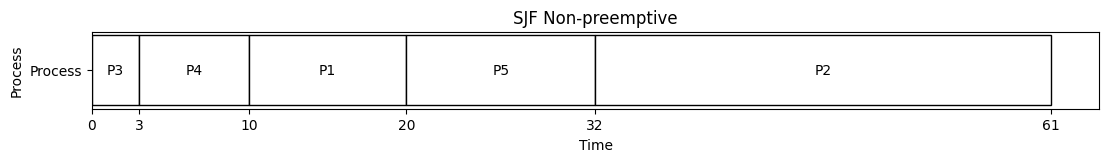

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               10             0   
P2                  0          29         2               61            32   
P3                  0           3         2                3             0   
P4                  0           7         2               10             3   
P5                  0          12         5               32            20   

         response time  
Process                 
P1                   0  
P2                  32  
P3                   0  
P4                   3  
P5                  20  


In [49]:

def SJF_nonpreem(_data):
    
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    
    # 스케줄링 시작
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                ready_queue.append(_data.loc[i])

        # burst time이 짧은 순으로 정렬
        ready_queue.sort(key= lambda x:x['burst time'])
        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐(burst time이 짧은 순으로 정렬된)의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 레디큐에 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소   
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('SJF Non-preemptive')           # 간트차트 그리기
    perfomance_data.append_data('SJF Non-preemptive',_data,time, using_time)    # 성능 데이터 추가


    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(SJF_nonpreem(data.copy()))

 * SJF(Shortest-Job-First) Preemptive  
 도착한 프로세스 중, CPU 버스트가 가장 짧은 프로세스를 CPU에 먼저 할당하는 스케줄링 방식(선점 형)  
 레디큐에 도착한 프로세스가 현재 CPU할당중인 프로세스보다 CPU버스트가 짧다면, CPU를 선점할 수 있음.

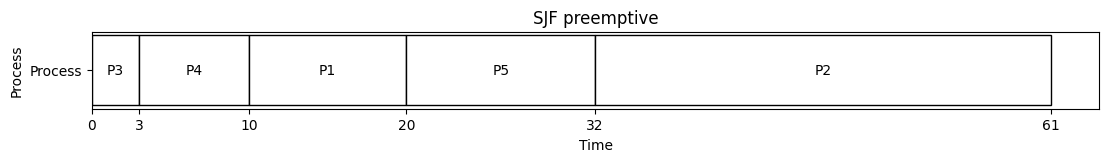

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               10             0   
P2                  0          29         2               61            32   
P3                  0           3         2                3             0   
P4                  0           7         2               10             3   
P5                  0          12         5               32            20   

         response time  
Process                 
P1                   0  
P2                  32  
P3                   0  
P4                   3  
P5                  20  


In [50]:
def SJF_preem(_data):
    
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                is_arrived = True
                ready_queue.append(_data.loc[i])

        # burst time이 짧은 순으로 정렬
        ready_queue.sort(key= lambda x:x['burst time'])
        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐(burst time이 짧은 순으로 정렬된)의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 프로세스가 레디큐에 진입했을 때, 버스트타임 기준으로 
        # context switching을 할지 말지 결정
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 burst time이 
            # 레디큐(burst time이 짧은 순으로 정렬된)의 첫번째 프로세스의 burst time보다 크다면
            # context switching
            if(_data.loc[allocated_process,'burst time']> ready_queue[0]['burst time']):
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['burst time'])

        is_arrived = False

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('SJF preemptive')           # 간트차트 그리기
    perfomance_data.append_data('SJF preemptive',_data,time, using_time)    # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(SJF_preem(data.copy()))

  * SRTF(Shortest-Remaining-Time-First)  
   도착한 프로세스 중, 남은시간이 가장 짧은 프로세스를 CPU에 먼저 할당하는 스케줄링 방식(선점 형)    
   레디큐에 도착한 프로세스가 현재 CPU할당중인 프로세스보다 남은시간이 짧다면, CPU를 선점할 수 있음.

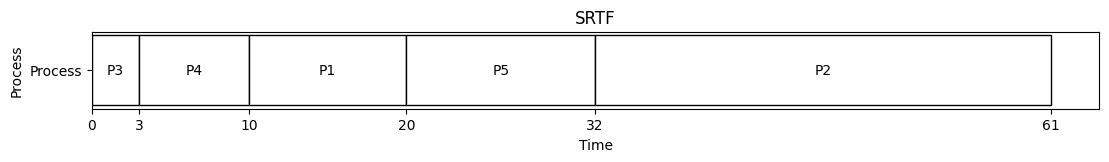

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               10             0   
P2                  0          29         2               61            32   
P3                  0           3         2                3             0   
P4                  0           7         2               10             3   
P5                  0          12         5               32            20   

         response time  
Process                 
P1                   0  
P2                  32  
P3                   0  
P4                   3  
P5                  20  


In [51]:
def SRTF(_data):
    
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                is_arrived = True
                ready_queue.append(_data.loc[i])
                # print(ready_queue[0]['remain time'])

        # remain time이 짧은 순으로 정렬
        ready_queue.sort(key= lambda x:x['remain time'])
        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐(remain time이 짧은 순으로 정렬된)의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 프로세스가 레디큐에 진입했을 때, remain time기준으로 
        # context switching을 할지 말지 결정
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 remain time이 
            # 레디큐(remain time이 짧은 순으로 정렬된)의 첫번째 프로세스의 remain time보다 크다면
            # context switching
            if(_data.loc[allocated_process,'remain time']> ready_queue[0]['remain time']):
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['remain time'])

        is_arrived = False
        

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('SRTF')          # 간트차트 그리기
    perfomance_data.append_data('SRTF',_data,time, using_time)  # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(SRTF(data.copy()))

  * Priority Scheduling Non-Preemptive  
  CPU는 가장 높은 우선순위(숫자가 낮은)를 가진 프로세스에 할당하는 스케줄링 방식(비선점 형)  
  우선순위가 같은 프로세스들은 선입 선처리(FCFS) 순서로 스케줄

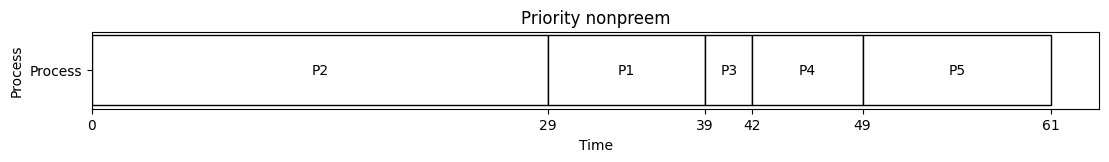

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               29            19   
P2                  0          29         2               29             0   
P3                  0           3         2               42            39   
P4                  0           7         2               49            42   
P5                  0          12         5               61            49   

         response time  
Process                 
P1                  19  
P2                   0  
P3                  39  
P4                  42  
P5                  49  


In [52]:
def Priority_nonpreem(_data):
        
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                ready_queue.append(_data.loc[i])

        # Priority가 작은 순(우선순위가 높은 순)으로 정렬
        ready_queue.sort(key= lambda x:x['Priority'])
        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐(우선순위가 높은 순으로 정렬된)의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('Priority nonpreem')      # 간트차트 그리기
    perfomance_data.append_data('Priority nonpreem',_data,time, using_time) # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(Priority_nonpreem(data.copy()))


  * Priority Scheduling Preemptive  
  CPU는 가장 높은 우선순위(숫자가 낮은)를 가진 프로세스에 할당하는 스케줄링 방식(선점 형)  
  우선순위가 같은 프로세스들은 선입 선처리(FCFS) 순서로 스케줄  
  레디큐에 도착한 프로세스가 현재 CPU할당중인 프로세스보다 우선순위가 높다면, CPU를 선점할 수 있음.
  

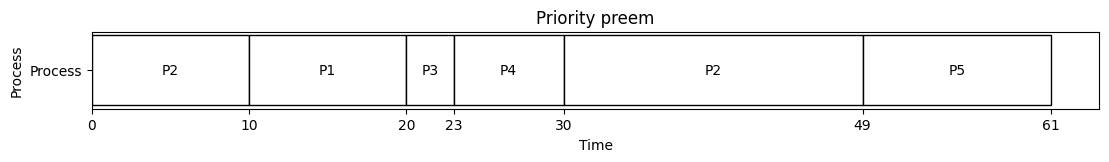

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               10             0   
P2                  0          29         2               49            20   
P3                  0           3         2               23            20   
P4                  0           7         2               30            23   
P5                  0          12         5               61            49   

         response time  
Process                 
P1                   0  
P2                  30  
P3                  20  
P4                  23  
P5                  49  


In [53]:
def Priority_preem(_data):
        
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                is_arrived = True
                ready_queue.append(_data.loc[i])

        # Priority가 작은 순(우선순위가 높은 순)으로 정렬
        ready_queue.sort(key= lambda x:x['Priority'])
        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐(우선순위가 높은 순으로 정렬된)의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 프로세스가 레디큐에 진입했을 때, Priority기준으로 
        # context switching을 할지 말지 결정
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 우선순위가
            # 레디큐(우선순위가 높은 순으로 정렬된)의 첫번째 프로세스의 우선순위보다 크다면
            # context switching
            if(_data.loc[allocated_process,'Priority']> ready_queue[0]['Priority']):
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['Priority'])

        is_arrived = False

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('Priority preem')         # 간트차트 그리기
    perfomance_data.append_data('Priority preem',_data,time, using_time)    # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):   
    print(Priority_preem(data.copy()))


  * RR(Round-Robin Scheduling)  
  기본적으로 선입 선처리 방식으로 스케줄링 하되, 실행중인 프로세스가 시간할당량 만큼 CPU를 사용할 경우  
  레디큐의 첫번째 프로세스가 CPU를 선점하고, 실행중이던 프로세스는 레디큐의 마지막으로 이동하는 방식
  

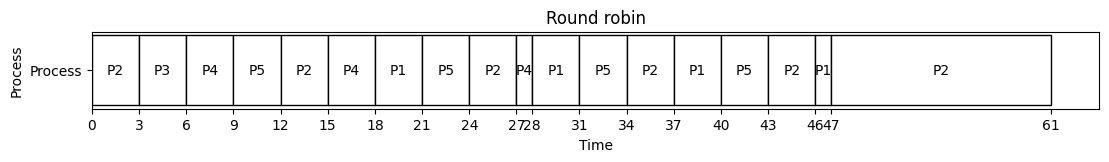

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               37            27   
P2                  0          29         2               61            32   
P3                  0           3         2                6             3   
P4                  0           7         2               28            21   
P5                  0          12         5               43            31   

         response time  
Process                 
P1                  36  
P2                  47  
P3                   3  
P4                  27  
P5                  40  


In [54]:
def Round_robin(_data):
    time_quantum = 3                # 시간 할당량
    allocated_time = 0              # 실행중인 프로세스가 얼마나 CPU를 사용하고있는지 나타내는 변수
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                ready_queue.append(_data.loc[i])
                is_arrived =True

        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐의 첫번째(가장 먼저 도착한) 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 프로세스가 레디큐에 진입했을 때
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 allocated time이 time_quauntum이상이라면
            # context switching
            if(allocated_time>=time_quantum):
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['Priority'])
                allocated_time = 0

        is_arrived = False

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time, allocated time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            allocated_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None
                allocated_time = 0

            # 레디큐가 비어있지 않고, time quantum만큼 CPU를 사용할 경우 context switching
            elif(allocated_time>=time_quantum and len(ready_queue)!=0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                chart_data.append_end(time)
                ready_queue.append(_data.loc[allocated_process])
                allocated_process = None
                allocated_time = 0


    # 모든 프로세스 종료 후                
    chart_data.drawChart('Round robin')        # 간트차트 그리기
    perfomance_data.append_data('Round robin',_data,time, using_time)   # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(Round_robin(data.copy()))

* Priority Scheduling with RR  
  CPU는 가장 높은 우선순위(숫자가 낮은)를 가진 프로세스에 할당하는 스케줄링 방식(선점 형)  
  우선순위가 같은 프로세스들은 라운드로빈 방식으로 스케줄  
  레디큐에 도착한 프로세스가 현재 CPU할당중인 프로세스보다 우선순위가 높다면, CPU를 선점할 수 있음.

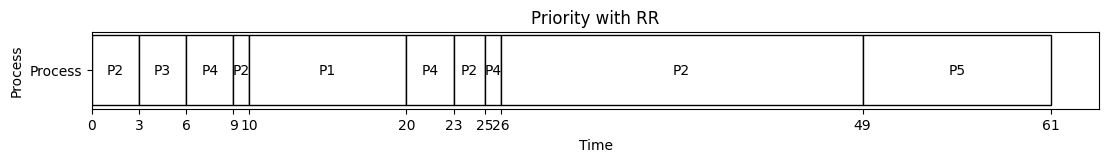

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               10             0   
P2                  0          29         2               49            20   
P3                  0           3         2                6             3   
P4                  0           7         2               26            19   
P5                  0          12         5               61            49   

         response time  
Process                 
P1                   0  
P2                  26  
P3                   3  
P4                  25  
P5                  49  


In [55]:
def Priority_with_RR(_data):
    time_quantum = 3                # 시간 할당량
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                ready_queue.append(_data.loc[i])
                is_arrived = True

        # Priority가 작은 순(우선순위가 높은 순)으로 정렬
        ready_queue.sort(key= lambda x:x['Priority'])

        
        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐(우선순위가 높은 순으로 정렬된)의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)

        # 프로세스가 레디큐에 진입했을 때, Priority기준으로 
        # context switching을 할지 말지 결정
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 우선순위가
            # 레디큐(우선순위가 높은 순으로 정렬된)의 첫번째 프로세스의 우선순위보다 크다면
            # context switching
            if((_data.loc[allocated_process,'Priority']> ready_queue[0]['Priority'])):
                _data.loc[allocated_process,'allocated time'] %=time_quantum
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['Priority'])
            # 우선순위가 같은 프로세스가 레디큐에 들어왔을 때, 실행중인 프로세스가 time quantum 이상으로 실행 중이면 context switching
            elif((_data.loc[allocated_process,'Priority'] == ready_queue[0]['Priority'] and _data.loc[allocated_process,'allocated time'] >= time_quantum)):
                _data.loc[allocated_process,'allocated time'] %=time_quantum
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['Priority'])


        is_arrived = False

        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'allocated time']+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

            # 레디큐가 비어있지 않고, time quantum만큼 CPU를 사용할 경우
            elif(_data.loc[allocated_process, 'allocated time']==time_quantum and len(ready_queue)!=0):
                # 우선순위가 높은 순으로 정렬된 레디큐의 첫번째 Process의 우선순위가 현재 CPU할당중인 프로세스의 우선순위보다 높거나 같을때
                # context switching
                if(_data.loc[allocated_process,'Priority']>=ready_queue[0]['Priority']):
                    _data.loc[allocated_process,'CPU_allocated'] = False
                    chart_data.append_end(time)
                    ready_queue.append(_data.loc[allocated_process])
                    _data.loc[allocated_process, 'allocated time'] = 0
                    allocated_process = None
                

    # 모든 프로세스 종료 후                
    chart_data.drawChart('Priority with RR')        # 간트차트 그리기
    perfomance_data.append_data('Priority with RR',_data,time, using_time)  # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(Priority_with_RR(data.copy()))

  * Multi Level Queue  
  우선순위마다 별도의 큐를 두며 우선순위가 높은 큐 먼저 스케줄링  
  우선순위가 같은 큐에서는 선입선출 방식으로 스케줄링

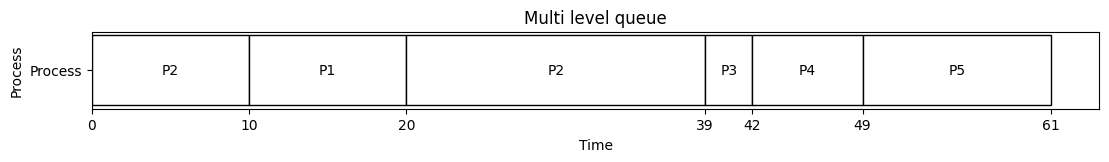

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               10             0   
P2                  0          29         2               39            10   
P3                  0           3         2               42            39   
P4                  0           7         2               49            42   
P5                  0          12         5               61            49   

         response time  
Process                 
P1                   0  
P2                  20  
P3                  39  
P4                  42  
P5                  49  


In [56]:
def Multi_level_queue(_data):
   
    ready_queue = defaultdict(list) # 여러개의 큐의 리스트. 각각의 요소는 dict 형이며 key: 0(우선순위), value:[p1, p2] 형태로 저장됨.
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수
    
    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                # 우선순위대로 별도의 레디큐에 삽입
                # EX) Priority = 1 이면 key: 1 인 큐에 삽입
                ready_queue[_data.loc[i,'Priority']].append(_data.loc[i])
                is_arrived = True
                

        cnt = 0                 # 현재 모든 레디큐에 있는 프로세스 개수,
        first_key = None        # 현재 비어있지 않은 우선순위가 가장 높은 레디큐의 이름
        for i in ready_queue.items():
          cnt += len(i[1])
          if(len(i[1])!=0):
              if(first_key == None or int(first_key)>int(i[0])):
                first_key = i[0]


    
        # CPU에 할당된 프로세스가 없고 모든 레디큐가 비어있지 않으면, 비어있지 않은 우선순위가 가장 높은 레디큐의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and cnt != 0):
            
            allocated_process = ready_queue[first_key].pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']

            chart_data.append_start(allocated_process,time)
            # cnt, first_key 업데이트
            cnt-=1
            first_key = None
            for i in ready_queue.items():
                if(first_key == None and len(i[1])!=0):
                    first_key = i[0]

        # 프로세스가 레디큐에 진입했을 때,
        # 더 높은 우선순위의 큐에 프로세스가 있으면 context switching
        if(is_arrived == True and cnt!=0):
            if(_data.loc[allocated_process,'Priority']> int(first_key)):
                _data.loc[allocated_process,'CPU_allocated'] = False
                ready_queue[_data.loc[allocated_process,'Priority']].insert(0,_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue[first_key].pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)

        is_arrived = False



        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('Multi level queue')      # 간트차트 그리기
    perfomance_data.append_data('Multi level queue',_data,time, using_time) # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(Multi_level_queue(data.copy()))

* Multi Level Feedback Queue  
    우선순위가 다른 여러개의 큐가 있으며, 큐 마다 스케줄링 방식을 다르게 설정.  
    프로세스는 특정 규칙에 따라 큐들 사이를 이동할 수 있는 방식

    * 멀티레벨 피드백 큐 규칙  
    1. 큐는 3개로 설정  
    2. Q0 -> RR(time quauntum = 8)  
    3. Q1 -> RR(time quauntum = 16)  
    4. Q2 -> FCFS  
    5. 모든 프로세스는 우선순위 관계없이 처음 도착시 Q0로 진입  
    6. Q0에서 나온 프로세스가 time quauntum을 다 쓰고도 완료되지 않으면 Q1으로 강등  
    7. Q1에서 나온 프로세스가 time quauntum을 다 쓰고도 완료되지 않으면 Q2으로 강등  
    8. Q2에서 20 동안 실행되지 못한 프로세스는 Q0로 승급  

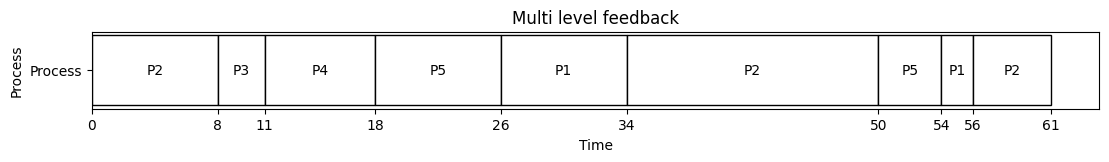

         arrival time  burst time  Priority  turnaround time  waiting time  \
Process                                                                      
P1                 10          10         1               46            36   
P2                  0          29         2               61            32   
P3                  0           3         2               11             8   
P4                  0           7         2               18            11   
P5                  0          12         5               54            42   

         response time  
Process                 
P1                  44  
P2                  56  
P3                   8  
P4                  11  
P5                  50  


In [57]:
def Multi_level_feedback(_data):
    

    ready_queue = defaultdict(list) # 여러개의 큐의 리스트
    ready_queue['0'] = []   # Q0
    ready_queue['1'] = []   # Q1
    ready_queue['2'] = []   # Q2

    # Q0 -> RR(time quauntum = 8)
    # Q1 -> RR(time quauntum = 16)
    time_quauntum = [8,16]  # 시간 할당량
    wherefrom = None        # 현재 실행중인 프로세스가 어떤 큐에서 나왔는지를 저장하는 변수

    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수

    # 스케줄링 시작.
    while True:
        # 모든 프로세스의 remain time이 0이면 루프 탈출.
        if(_data['remain time'].sum()==0):
            break
        
        # 도착시각이 현재시각과 같아지면 ready queue에 삽입
        for i in _data.index:
            if(_data.loc[i,'arrival time'] == time):
                # 우선순위 관계없이 모든 프로세스는 Q0에 삽입
                ready_queue['0'].append(_data.loc[i])
                is_arrived = True

       
        cnt = 0                 # 현재 모든 레디큐에 있는 프로세스 개수
        first_key = None        # 현재 비어있지 않은 우선순위가 가장 높은 레디큐의 이름
        for i in ready_queue.items():
          cnt += len(i[1])
          if(len(i[1])!=0):
              if(first_key == None or int(first_key)>int(i[0])):
                first_key = i[0]
          

    
        # CPU에 할당된 프로세스가 없고 모든 레디큐가 비어있지 않으면, 비어있지 않은 우선순위가 가장 높은 레디큐의 첫번째 프로세스를 CPU에 할당
        if(allocated_process == None and cnt != 0):
            wherefrom = int(first_key)
            allocated_process = ready_queue[first_key].pop(0).name
            _data.loc[allocated_process,'CPU_allocated'] =True
            _data.loc[allocated_process,'response time'] = time - _data.loc[allocated_process,'arrival time']
            chart_data.append_start(allocated_process,time)
            
            # 현재 비어있지 않은 우선순위가 가장 높은 레디큐의 이름, 개수 업데이트
            cnt-=1
            first_key = None
            for i in ready_queue.items():
                if(first_key == None and len(i[1])!=0):
                    first_key = i[0]

        # 프로세스가 레디큐에 진입했을 때,
        if(is_arrived == True and cnt!=0):
            # 현재 비어있지않은 가장 높은 우선순위의 큐가
            # 현재 실행중인 프로세스가 있던 큐의 우선순위보다 높을경우
            # context switching
            if((wherefrom > int(first_key))):
                ready_queue[str(wherefrom)].insert(0,_data.loc[allocated_process])
                _data.loc[allocated_process,'CPU_allocated'] = False
                chart_data.append_end(time)

                wherefrom = int(first_key)
                allocated_process = ready_queue[first_key].pop(0).name
                _data.loc[allocated_process,'CPU_allocated'] = True
                chart_data.append_start(allocated_process,time)

        is_arrived = False



        # 시간 흐름
        time+=1

        # CPU 할당중이 아니고, 끝나지 않았으며, 도착한 프로세스들의 waiting time 증가
        for i in _data.index:
            if(_data.loc[i,'CPU_allocated'] == False and _data.loc[i,'remain time'] != 0 and _data.loc[i,'arrival time']<time):
                _data.loc[i,'waiting time'] +=1

        # Q2에 있는 프로세스들의 대기시간 증가
        for i, v in enumerate(ready_queue['2']):
            v['waited on Q2'] += 1
            # Q2에서의 대기시간이 20이 될 경우 Q0로 승급
            if(v['waited on Q2'] == 20):
                v['waited on Q2'] = 0
                ready_queue['0'].append(ready_queue['2'].pop(i))
                is_arrived = True



        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소
        if(allocated_process != None):
            using_time+=1
            _data.loc[allocated_process,'remain time']-=1

            # 현재 실행중인 프로세스가 Q0 or Q1에서 나온 프로세스일 경우 allocated time 증가
            if(wherefrom == 0 or wherefrom == 1):
                _data.loc[allocated_process,'allocated time'] +=1

            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료
            if(_data.loc[allocated_process,'remain time'] == 0):
                _data.loc[allocated_process,'CPU_allocated'] = False
                _data.loc[allocated_process,'turnaround time'] = time - _data.loc[allocated_process,'arrival time']

                chart_data.append_end(time)
                
                allocated_process = None

            # 모든 레디큐가 비어있지 않고,
            # 현재 실행중인 프로세스가 스케줄링 방식이 RR인 큐에서 나왔으며,
            # 해당 큐의 time quantum만큼 CPU를 사용할 경우
            # 할당 종료 및 한단계 낮은 우선순위의 큐에 삽입
            elif(cnt!=0):
                if((wherefrom == 0 or wherefrom ==1) and (_data.loc[allocated_process,'allocated time']== time_quauntum[wherefrom])):
                    _data.loc[allocated_process,'CPU_allocated'] = False
                    chart_data.append_end(time)
                    ready_queue[str(wherefrom + 1)].append(_data.loc[allocated_process])
                    _data.loc[allocated_process,'allocated time'] = 0
                    allocated_process = None
                    wherefrom = None
        

    # 모든 프로세스 종료 후
    chart_data.drawChart('Multi level feedback')       # 간트차트 그리기
    perfomance_data.append_data('Multi level feedback',_data,time, using_time)  # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['CPU_allocated', 'remain time', 'allocated time', 'waited on Q2'],axis = 1)


if(is_realtime == False):
    print(Multi_level_feedback(data.copy()))

* 성능분석  
CPU utilization  
Throughput  
average turnaround time  
average waiting time   
average response time  
을 각각의 속성마다 성능이 좋은 순으로 정렬하여 10부터 0까지의 점수를 부여함.  
같은 값은 같은 점수로 분류.  
모든 점수를 합산하여 가장 높은 점수를 가진 알고리즘을 제일 나은 방법으로 판정.

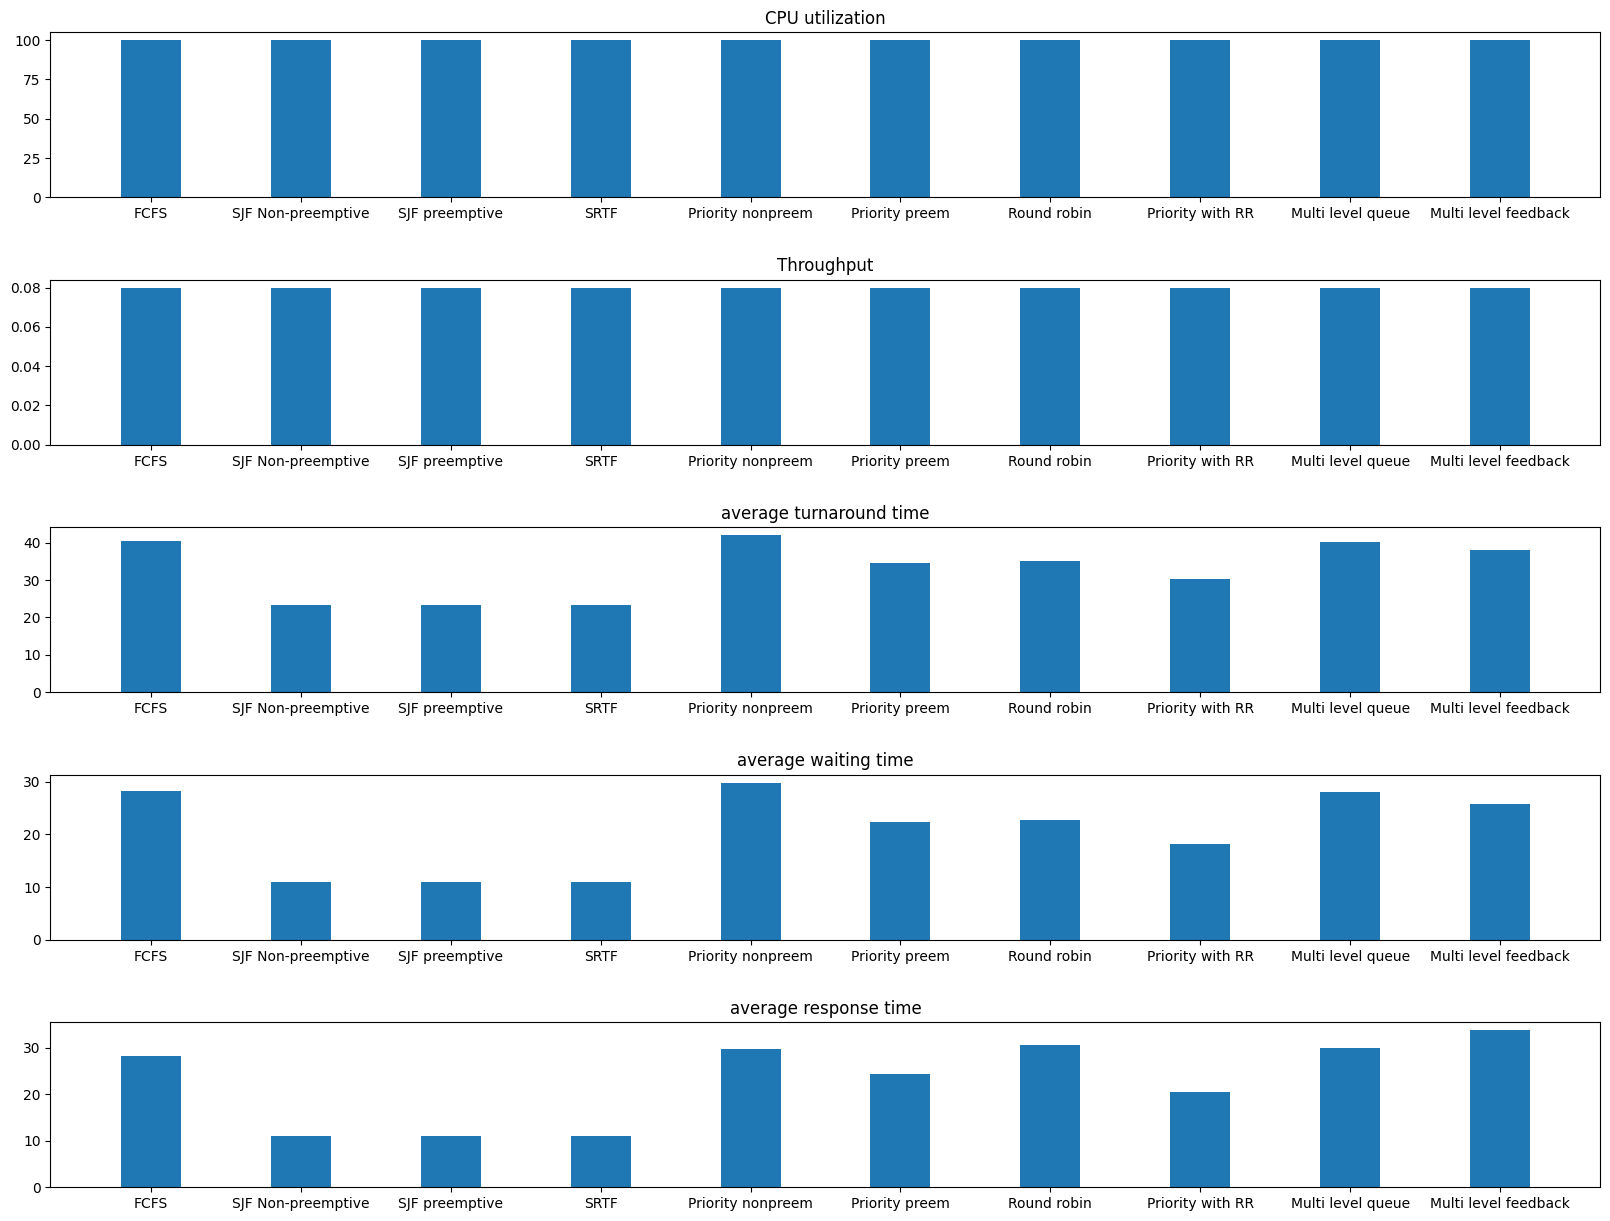

현재 프로레스 셋에서 가장 성능이 좋은 알고리즘은 SJF Non-preemptive, SJF preemptive, SRTF 이다.
                     CPU utilization  Throughput  average turnaround time  \
Algorithm                                                                   
SJF Non-preemptive            100.0%        0.08                     23.2   
SJF preemptive                100.0%        0.08                     23.2   
SRTF                          100.0%        0.08                     23.2   
Priority with RR              100.0%        0.08                     30.4   
Priority preem                100.0%        0.08                     34.6   
Round robin                   100.0%        0.08                     35.0   
FCFS                          100.0%        0.08                     40.4   
Multi level queue             100.0%        0.08                     40.2   
Multi level feedback          100.0%        0.08                     38.0   
Priority nonpreem             100.0%        0.08                     42.0   

  

In [58]:
if(is_realtime == False):

    df = perfomance_data.perfomance.copy()

    # 5가지 성능의 그래프를 그릴 서브플롯 5가지를 만듦.
    fig, ax = plt.subplots(5,1, figsize=(20, 15))

    df['CPU utilization'] *=100

    # 그래프 그리기
    for i, col in enumerate(df.columns):
        ax[i].bar(x= df.index, height= df[col], width=0.4)
        ax[i].set_title(col)

    # 그래프간의 간격 조정
    plt.subplots_adjust(hspace=0.5)

    # 그래프 보여주기
    plt.show()


    # 성능 분석
    cols = ['CPU utilization', 'Throughput', 'average turnaround time', 'average waiting time', 'average response time']

    df_cp = df.copy()
    df_cp['point'] = 0   # 성능지표를 비교할 point 속성 추가

    # 컬럼별로
    for col in cols:
        pt = 10        
        prev = None
        # CPU utilization, Throughput은 숫자가 높은게 성능이 좋으므로 내림차순으로 정렬
        if(col=='CPU utilization' or col == 'Throughput'):
            df_cp = df_cp.sort_values(col, ascending= False)
        # 나머지는 오름차순으로 정렬
        else :
            df_cp = df_cp.sort_values(col)

        # 성능순으로 정렬된 인덱스에 포인트 부여
        for idx in df_cp.index:
            if(col=='CPU utilization' or col == 'Throughput'):
                if(prev != None and prev > df_cp.loc[idx, col]):
                    pt -=1
                prev = df_cp.loc[idx, col]
                df_cp.loc[idx,'point'] += pt

            else :
                if(prev != None and prev < df_cp.loc[idx, col]):
                    pt -=1
                prev = df_cp.loc[idx, col]
                df_cp.loc[idx,'point'] += pt

    # 포인트 순으로 정렬
    df_cp = df_cp.sort_values('point', ascending= False)



    # 가장 포인트가 높은 알고리즘들을 선정해서 출력
    best_algo = str() + df_cp.index[0]
    for i, idx in enumerate(df_cp.index):
        if(df_cp.loc[idx, 'point'] == df_cp.iloc[0]['point'] and i != 0):
            best_algo += ', {}'.format(idx)

    df_cp['CPU utilization'] = df_cp['CPU utilization'].astype(str) + '%'
   
    print('현재 프로레스 셋에서 가장 성능이 좋은 알고리즘은 {} 이다.'.format(best_algo))
    print(df_cp)


### Real time  
모든 스케줄링에서 데드라인 = 주기 라고 가정  
여기서는 성능평가를 하지 않고,  
마감시간을 지키는지 못 지키는지만 판단

* Rate Monotonic Scehduling  
모든 프로세스는 시스템에 진입하게 되면 주기(period)가 짧은 순으로 높은 우선순위가 부여된다.  
즉 CPU를 더 자주 필요로 하는 프로세스에 더 높은 우선순위를 주는 스케줄링 기법이다.  
낮은 우선순위의 프로세스가 실행중이고 높은 우선순위의 프로세스가 실행 준비가 되면,  
높은 우선순위의 프로세스가 낮은 우선순위의 프로세스를 선점한다. 

In [59]:
def Rate_Monotonic_Scehduling(_data):
    ready_queue = list()            # 여러개의 큐의 리스트. 각각의 요소는 dict 형이며 key: 0(우선순위), value:[p1, p2] 형태로 저장됨.
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수
    period_lcm = reduce(lcm,list(_data['period'])) # 프로세스 주기들의 최소공배수


    

    # 스케줄링 시작
    while True:
        string = '' # 도착시간 화살표를 간트차트에 나타내기 위한 변수

        
        # 프로세스 주기들의 최소공배수만큼 실행
        if(time == period_lcm + 1):
            break
        
        for i in _data.index:
             # 현재시각이 프로세스 주기가 되면 레디큐에 삽입
            if(_data.loc[i,'period'] * _data.loc[i,'how many'] == time):

                # 화살표데이터에 어떤 프로세스의 이름을 적을지 저장하는 변수 string에 프로세스 이름 추가
                if(len(string)== 0):
                    string+=i
                else:
                    string+=',{}'.format(i)

                _data.loc[i,'how many'] += 1
                # 데드라인은 프로세스의 다음 주기로 설정.
                _data.loc[i,'dead line'] = _data.loc[i,'period'] * _data.loc[i,'how many']
                _data.loc[i,'remain time to dead line'] = _data.loc[i,'dead line']
                _data.loc[i,'remain time'] = _data.loc[i,'burst time']
                ready_queue.append(_data.loc[i])

                is_arrived = True

        # 도착한 프로세스가 있으면 화살표데이터 추가
        if(is_arrived == True):
            chart_data.arrival_data.append([string,time])



        # dead line이 짧은 순으로 정렬
        ready_queue.sort(key= lambda x:x['period'])


        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐의 첫번째(가장 먼저 도착한) 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name

            chart_data.append_start(allocated_process,time)


        # 프로세스가 레디큐에 진입했을 때, dead line 기준으로 
        # context switching을 할지 말지 결정
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 dead line이 
            # 레디큐(dead line이 짧은 순으로 정렬된)의 첫번째 프로세스의 dead line보다 크다면
            # context switching
            if(_data.loc[allocated_process,'period']> ready_queue[0]['period']):
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['period'])

        is_arrived = False
        

        # 시간 흐름
        time+=1

        # 끝나지 않은 프로세스들의 데드라인까지 남은 시간 감소
        for i in _data.index:
            if(_data.loc[i,'remain time'] != 0):
                _data.loc[i,'remain time to dead line'] -=1
                # 데드라인까지 남은 시간이 프로세스가 완료되기까지 남은 시간보다 작다면
                # 데드라인을 맞출 수 없으므로 스케줄링 종료
                if(_data.loc[i,'remain time to dead line'] < _data.loc[i,'remain time']):
                    return '이 프로세스셋은 Rate Monotonic Scheduling으로 마감시간을 맞출 수 없음.'

        # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소 
        if(allocated_process != None):
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료 
            if(_data.loc[allocated_process,'remain time'] == 0):
                chart_data.append_end(time)
                allocated_process = None

    # 모든 프로세스 종료 후
    chart_data.drawChart('Rate Monotonic Scheduling')        # 간트차트그리기
    # perfomance_data.append_data('Rate Monotonic Scheduling',_data,time, using_time)  # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['dead line', 'remain time', 'remain time to dead line', 'how many'],axis = 1)


    


    
    
    
if(is_realtime == True):
    print(Rate_Monotonic_Scehduling(data.copy()))

* Earliest Deadline First Scehduling(EDF)  
마감시간에따라서 우선순위를 동적으로 부여하는 스케줄링 방식.  
시스템에 프로세스가 새로 진입할 때,  
마감시간까지 남은 시간이 더 적은 프로세스가 더 높은 우선순위를 가짐.

In [60]:
def Earliest_Deadline_First_Scehduling(_data):
    ready_queue = list()            # 레디큐
    time = 0                        # 시간이 흘러가는것을 체크하기위한 변수
    using_time = 0                  # CPU에 할당된 프로세스가 있을때만 흘러가는 시간
    allocated_process = None        # 현재 CPU에 할당된 프로세스의 이름을 담은 변수
    chart_data = GanntChart()       # 간트차트를 그리기 위한 객체 생성
    is_arrived = False              # 레디큐에 프로세스가 도착했음을 알기위한 변수
    period_lcm = reduce(lcm,list(_data['period'])) # 프로세스 주기들의 최소공배수
    # 스케줄링 시작
    while True:
        string = '' # 도착시간 화살표를 간트차트에 나타내기 위한 변수
        
        # 프로세스 주기들의 최소공배수만큼 실행
        if(time == period_lcm + 1):
            break
        

        for i in _data.index:
             # 현재시각이 프로세스 주기가 되면 레디큐에 삽입
            if(_data.loc[i,'period'] * _data.loc[i,'how many'] == time):

                # 화살표데이터에 어떤 프로세스의 이름을 적을지 저장하는 변수 string
                if(len(string)== 0):
                    string+=i
                else:
                    string+=',{}'.format(i)
                    
                _data.loc[i,'how many'] += 1
                # 데드라인은 프로세스의 다음 주기로 설정.
                _data.loc[i,'dead line'] = _data.loc[i,'period'] * _data.loc[i,'how many']
                _data.loc[i,'remain time to dead line'] = _data.loc[i,'dead line'] - time
                _data.loc[i,'remain time'] = _data.loc[i,'burst time']
                ready_queue.append(_data.loc[i])

                is_arrived = True

        # 도착한 프로세스가 있으면 화살표데이터 추가
        if(is_arrived == True):
            chart_data.arrival_data.append([string,time])

        # dead line이 짧은 순으로 정렬
        ready_queue.sort(key= lambda x:x['remain time to dead line'])


        # CPU에 할당된 프로세스가 없고 레디큐가 비어있지 않으면, 레디큐의 첫번째(가장 먼저 도착한) 프로세스를 CPU에 할당
        if(allocated_process == None and len(ready_queue) != 0):
            allocated_process = ready_queue.pop(0).name

            chart_data.append_start(allocated_process,time)


        # 프로세스가 레디큐에 진입했을 때, remain time to dead line 기준으로 
        # context switching을 할지 말지 결정
        if(is_arrived == True and len(ready_queue) != 0):
            # CPU할당중인 프로세스의 reamain time to dead line이 
            # 레디큐(remain time to dead line이 짧은 순으로 정렬된)의 첫번째 프로세스의 remain time to dead line보다 크다면
            # context switching
            if(_data.loc[allocated_process,'remain time to dead line']> ready_queue[0]['remain time to dead line']):
                ready_queue.append(_data.loc[allocated_process])
                chart_data.append_end(time)

                allocated_process = ready_queue.pop(0).name
                chart_data.append_start(allocated_process,time)
                ready_queue.sort(key= lambda x:x['remain time to dead line'])

        is_arrived = False
        

        # 시간 흐름
        time+=1

          # CPU 할당중인 프로세스가 있으면 using time 증가, 할당중인 프로세스의 남은시간 감소 
        if(allocated_process != None):
            _data.loc[allocated_process,'remain time']-=1
            # 해당 프로세스의 남은시간이 0이 되면,(프로세스 종료) 할당 종료 
            if(_data.loc[allocated_process,'remain time'] == 0):
                chart_data.append_end(time)
                allocated_process = None

        # 끝나지 않은 프로세스들의 데드라인까지 남은 시간 감소
        for i in _data.index:
            if(_data.loc[i,'remain time'] != 0 and time < (_data.loc[i,'how many']*_data.loc[i,'period'])):
                _data.loc[i,'remain time to dead line'] -=1
                # 데드라인까지 남은 시간이 프로세스가 완료되기까지 남은 시간보다 작다면
                # 데드라인을 맞출 수 없으므로 스케줄링 종료
                if(_data.loc[i,'remain time to dead line'] < _data.loc[i,'remain time']):
                    print(_data.loc[i])
                    print(time)
                    return '이 프로세스셋은 Rate Monotonic Scheduling으로 마감시간을 맞출 수 없음.'

      

    # 모든 프로세스 종료 후
    chart_data.drawChart('Earliest_Deadline_First_Scehduling')        # 간트차트그리기
    # perfomance_data.append_data('Rate Monotonic Scheduling',_data,time, using_time)  # 성능데이터 추가

    # 필요없는 열 제거 후 리턴
    return _data.drop(['dead line', 'remain time', 'remain time to dead line', 'how many'],axis = 1)


    


    
    
    
if(is_realtime == True):
    print(Earliest_Deadline_First_Scehduling(data.copy()))